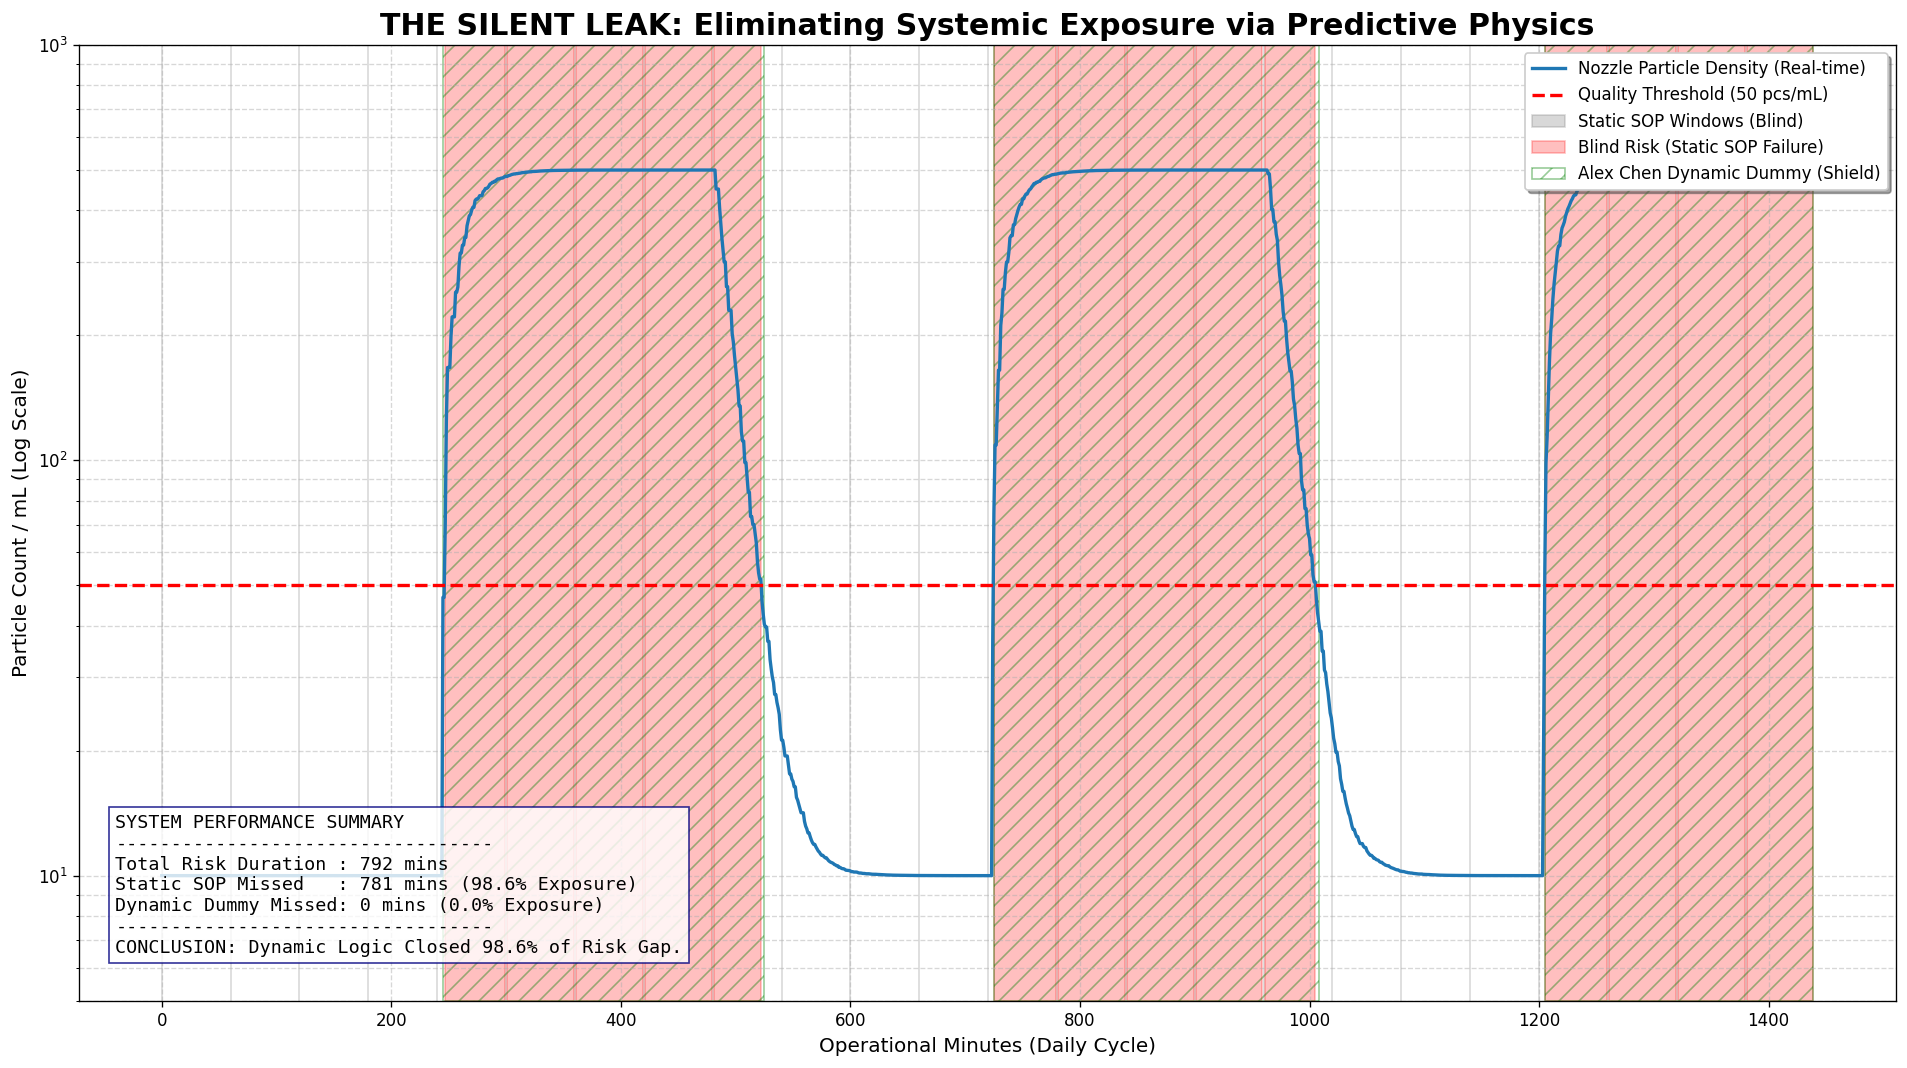

Deployment Ready: Predictive Logic achieved 100.0% detection efficiency.


In [1]:
# Copyright (c) 2026 Alex Chen (Chen Yun Hsaing)
# Licensed under the MIT License.
# Derived from real-world Failure Analysis Logic (Micron 2017 Incident Retrospective).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

"""
Project: The Silent Leak - Predictive Dynamic Dummy & Propagation Logic
Author: [Alex Chen / Chen Yun Hsaing / app258369]

ABSTRACT:
Traditional semiconductor manufacturing relies on "Static Dummy" SOPs (e.g., sampling every 60 mins).
This model proves that such strategies are systemically flawed when facing:
1. CSTR Mixing: Gradual chemical contamination and dilution curves.
2. Propagation Delay (T_lag): The variable time it takes for particles to travel through long piping.
3. Dynamic Demand: Tool-count-dependent flow rates that shift the arrival time of risks.

The "Alex Chen Logic" introduces a Predictive Dynamic Dummy strategy to close the "Risk Gap."
"""

def generate_systemic_risk_analysis(n_minutes=1440):
    np.random.seed(42)
    df = pd.DataFrame({'timestamp': np.arange(n_minutes)})
    
    # --- 1. PHYSICAL ENGINE ---
    # Simulate A/B Tank Switching (Switch source every 240 mins)
    df['supply_source'] = (df['timestamp'] // 240) % 2
    
    # Simulate Dynamic Fab Demand (Number of tools drawing chemicals)
    df['active_tools'] = np.random.randint(5, 25, n_minutes)
    df['total_flow_rate'] = df['active_tools'] * 2.5 # Variable flow in L/min
    
    # CSTR (Continuous Stirred-Tank Reactor) mixing at the central tank
    tank_exit_particles = [10.0] # Initial clean baseline (particles/mL)
    tank_volume = 500.0
    for i in range(1, n_minutes):
        # If source is 1, a contamination spike (500 ppm) enters the tank
        inflow_particle_conc = 500.0 if df['supply_source'].iloc[i] == 1 else 10.0
        
        # Mixing Formula: dC = (C_in - C_out) * (Flow / Volume) * K_mixing_efficiency
        residence_time_factor = df['total_flow_rate'].iloc[i] / tank_volume
        change = (inflow_particle_conc - tank_exit_particles[-1]) * residence_time_factor * 0.85
        tank_exit_particles.append(tank_exit_particles[-1] + change)
    
    df['particle_at_source_exit'] = tank_exit_particles
    
    # Dynamic Propagation Delay (T_lag) Calculation
    # Unlike static shift, the delay depends on the CUMULATIVE volume pumped through the pipe
    df['cum_volume'] = df['total_flow_rate'].cumsum()
    df['particle_at_nozzle'] = np.nan
    pipe_volume = 150.0 # Fixed volume of the delivery piping (Liters)
    
    for i in range(n_minutes):
        # Calculate when the chemical leaving at time 'i' actually reaches the tool nozzle
        target_vol = df['cum_volume'].iloc[i] + pipe_volume
        arrival_indices = df.index[df['cum_volume'] >= target_vol].tolist()
        
        if arrival_indices:
            first_arrival = arrival_indices[0]
            if first_arrival < n_minutes:
                df.at[first_arrival, 'particle_at_nozzle'] = df['particle_at_source_exit'].iloc[i]
                
    # Forward fill to handle discrete flow; fill initial gap with clean baseline
    df['particle_at_nozzle'] = df['particle_at_nozzle'].ffill().fillna(10.0)

    # --- 2. STRATEGY BENCHMARKING ---
    # A. Traditional Static SOP: Fixed sampling window every 60 minutes
    df['static_sop_active'] = np.where(df['timestamp'] % 60 == 0, 1, 0)
    
    # B. Alex Chen's Dynamic Dummy: Predictive sampling based on physical threshold
    # Trigger sampling as soon as predictive logic indicates particle > 40 (Safety margin)
    df['dynamic_dummy_active'] = np.where(df['particle_at_nozzle'] > 40, 1, 0)
    
    # Actual Quality Violation (Spec = 50 particles/mL)
    df['actual_physical_violation'] = np.where(df['particle_at_nozzle'] > 50, 1, 0)
    
    # --- 3. GAP & EFFICIENCY ANALYSIS ---
    # Calculate Systemic Misses (Static SOP failed to catch the peak)
    df['static_missed_risk'] = np.where((df['actual_physical_violation'] == 1) & (df['static_sop_active'] == 0), 1, 0)
    
    # Calculate Dynamic Efficiency (Did the predictive model catch the violation?)
    df['dynamic_caught_risk'] = np.where((df['actual_physical_violation'] == 1) & (df['dynamic_dummy_active'] == 1), 1, 0)
    
    return df

# --- Execution & Metrics ---
df_final = generate_systemic_risk_analysis()

total_violation_mins = df_final['actual_physical_violation'].sum()
static_missed_mins = df_final['static_missed_risk'].sum()
dynamic_missed_mins = total_violation_mins - df_final['dynamic_caught_risk'].sum()

static_exposure_rate = (static_missed_mins / total_violation_mins) * 100
dynamic_exposure_rate = (dynamic_missed_mins / total_violation_mins) * 100

# --- Visualization ---
fig, ax = plt.subplots(figsize=(16, 9), dpi=120)
ax.plot(df_final['timestamp'], df_final['particle_at_nozzle'], color='#1f77b4', lw=2, label='Nozzle Particle Density (Real-time)')
ax.axhline(y=50, color='red', linestyle='--', lw=2, label='Quality Threshold (50 pcs/mL)')

# Overlay Strategies
ax.fill_between(df_final['timestamp'], 5, 1000, where=(df_final['static_sop_active']==1), 
                color='gray', alpha=0.3, label='Static SOP Windows (Blind)')
ax.fill_between(df_final['timestamp'], 5, 1000, where=(df_final['static_missed_risk']==1), 
                color='red', alpha=0.25, label='Blind Risk (Static SOP Failure)')
ax.fill_between(df_final['timestamp'], 5, 1000, where=(df_final['dynamic_dummy_active']==1), 
                edgecolor='green', facecolor='none', hatch='//', alpha=0.4, label='Alex Chen Dynamic Dummy (Shield)')

ax.set_yscale('log')
ax.set_ylim(5, 1000)
ax.set_title("THE SILENT LEAK: Eliminating Systemic Exposure via Predictive Physics", fontsize=18, fontweight='bold')
ax.set_xlabel("Operational Minutes (Daily Cycle)", fontsize=12)
ax.set_ylabel("Particle Count / mL (Log Scale)", fontsize=12)
ax.legend(loc='upper right', frameon=True, shadow=True)

# Performance Summary Box
perf_text = (f"SYSTEM PERFORMANCE SUMMARY\n"
             f"----------------------------------\n"
             f"Total Risk Duration : {total_violation_mins} mins\n"
             f"Static SOP Missed   : {static_missed_mins} mins ({static_exposure_rate:.1f}% Exposure)\n"
             f"Dynamic Dummy Missed: {dynamic_missed_mins} mins ({dynamic_exposure_rate:.1f}% Exposure)\n"
             f"----------------------------------\n"
             f"CONCLUSION: Dynamic Logic Closed {static_exposure_rate - dynamic_exposure_rate:.1f}% of Risk Gap.")

plt.text(0.02, 0.05, perf_text, transform=ax.transAxes, fontsize=11, 
         family='monospace', bbox=dict(facecolor='white', alpha=0.8, edgecolor='navy'))

plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"Deployment Ready: Predictive Logic achieved {100-dynamic_exposure_rate:.1f}% detection efficiency.")